# CarND Object Detection Lab

Let's get started!

In [ ]:
#!pip install tensorflow==1.15.2
#!pip install tensorflow-gpu==1.15.2
#!pip install moviepy
#!pip install -U kora
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
from PIL import ImageFont
import time
from scipy.stats import norm

%matplotlib inline
plt.style.use('ggplot')
print(tf.version)



<module 'tensorflow._api.v1.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow_core/_api/v1/version/__init__.py'>


## MobileNets

[*MobileNets*](https://arxiv.org/abs/1704.04861), as the name suggests, are neural networks constructed for the purpose of running very efficiently (high FPS, low memory footprint) on mobile and embedded devices. *MobileNets* achieve this with 3 techniques:

1. Perform a depthwise convolution followed by a 1x1 convolution rather than a standard convolution. The 1x1 convolution is called a pointwise convolution if it's following a depthwise convolution. The combination of a depthwise convolution followed by a pointwise convolution is sometimes called a separable depthwise convolution.
2. Use a "width multiplier" - reduces the size of the input/output channels, set to a value between 0 and 1.
3. Use a "resolution multiplier" - reduces the size of the original input, set to a value between 0 and 1.

These 3 techniques reduce the size of cummulative parameters and therefore the computation required. Of course, generally models with more paramters achieve a higher accuracy. *MobileNets* are no silver bullet, while they perform very well larger models will outperform them. ** *MobileNets* are designed for mobile devices, NOT cloud GPUs**. The reason we're using them in this lab is automotive hardware is closer to mobile or embedded devices than beefy cloud GPUs.

## *MobileNet* SSD

In this section you'll use a pretrained *MobileNet* [SSD](https://arxiv.org/abs/1512.02325) model to perform object detection. You can download the *MobileNet* SSD and other models from the [TensorFlow detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) (*note*: we'll provide links to specific models further below). [Paper](https://arxiv.org/abs/1611.10012) describing comparing several object detection models.

Alright, let's get into SSD!

### Single Shot Detection (SSD)

Many previous works in object detection involve more than one training phase. For example, the [Faster-RCNN](https://arxiv.org/abs/1506.01497) architecture first trains a Region Proposal Network (RPN) which decides which regions of the image are worth drawing a box around. RPN is then merged with a pretrained model for classification (classifies the regions). The image below is an RPN:

![Faster-RCNN Visual](./assets/faster-rcnn.png)

The SSD architecture is a single convolutional network which learns to predict bounding box locations and classify the locations in one pass. Put differently, SSD can be trained end to end while Faster-RCNN cannot. The SSD architecture consists of a base network followed by several convolutional layers: 

![SSD Visual](./assets/ssd_architecture.png)

**NOTE:** In this lab the base network is a MobileNet (instead of VGG16.)

#### Detecting Boxes

SSD operates on feature maps to predict bounding box locations. Recall a feature map is of size $D_f * D_f * M$. For each feature map location $k$ bounding boxes are predicted. Each bounding box carries with it the following information:

* 4 corner bounding box **offset** locations $(cx, cy, w, h)$
* $C$ class probabilities $(c_1, c_2, ..., c_p)$

SSD **does not** predict the shape of the box, rather just where the box is. The $k$ bounding boxes each have a predetermined shape. This is illustrated in the figure below:

![](./assets/ssd_feature_maps.png)

The shapes are set prior to actual training. For example, In figure (c) in the above picture there are 4 boxes, meaning $k$ = 4.

### SSD Feature Maps

It would be a good exercise to read the SSD paper prior to a answering the following questions.

***Q: Why does SSD use several differently sized feature maps to predict detections?***

A: Differently sized feature maps allow for the network to learn to detect objects at different
resolutions. This is illustrated in the figure with the 8x8 and 4x4 feature maps. This may remind you
of skip connections in fully convolutional networks.

The current approach leaves us with thousands of bounding box candidates, clearly the vast majority of them are nonsensical.

### Filtering Bounding Boxes

***Q: What are some ways which we can filter nonsensical bounding boxes?***

A: The SSD paper does 2 things:

1. Filters boxes based on IoU metric. For example, if a box has an IoU score
less than 0.5 on all ground truth boxes it's removed.

2. *Hard negative mining*. This is a fancy way of saying "search for negatives examples
the highest confidence". For example, a box that misclassifies a dog as a cat with 80% confidence.
The authors of the SSD paper limit the positive to hard negative ratio to 3:1 at most. The actual positive to negative ratio is typically much higher and the number of boxes are typically reduced substantially.

#### Loss

With the final set of matched boxes we can compute the loss:

$$
L = \frac {1} {N} * ( L_{class} + L_{box})
$$

where $N$ is the total number of matched boxes, $L_{class}$ is a softmax loss for classification, and $L_{box}$ is a L1 smooth loss representing the error of the matched boxes with the ground truth boxes. L1 smooth loss is a modification of L1 loss which is more robust to outliers. In the event $N$ is 0 the loss is set 0.



###  SSD Summary

* Starts from a base model pretrained on ImageNet. 
* The base model is extended by several convolutional layers.
* Each feature map is used to predict bounding boxes. Diversity in feature map size allows object detection at different resolutions.
* Boxes are filtered by IoU metrics and hard negative mining.
* Loss is a combination of classification (softmax) and dectection (smooth L1)
* Model can be trained end to end.

## Object Detection Inference

In this part of the lab you'll detect objects using pretrained object detection models. You can download the latest pretrained models from the [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md), although do note that you may need a newer version of TensorFlow (such as v1.8) in order to use the newest models.

We are providing the download links for the below noted files to ensure compatibility between the included environment file and the models.

[SSD_Mobilenet 11.6.17 version](http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_11_06_2017.tar.gz)

[RFCN_ResNet101 11.6.17 version](http://download.tensorflow.org/models/object_detection/rfcn_resnet101_coco_11_06_2017.tar.gz)

[Faster_RCNN_Inception_ResNet 11.6.17 version](http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017.tar.gz)

Make sure to extract these files prior to continuing!

In [ ]:
# Frozen inference graph files. NOTE: change the path to where you saved the models.
SSD_GRAPH_FILE = 'frozen_inference_graph.pb'
RFCN_GRAPH_FILE = 'frozen_inference_graph.pb'
FASTER_RCNN_GRAPH_FILE = 'frozen_inference_graph.pb'

#'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
#'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
#'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
#'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',

Below are utility functions. The main purpose of these is to draw the bounding boxes back onto the original image.

In [ ]:
# Colors (one for each class)
cmap = ImageColor.colormap
print("Number of colors =", len(cmap))
COLOR_LIST = sorted([c for c in cmap.keys()])

#
# Utility funcs
#

def filter_boxes(min_score, boxes, scores, classes):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if scores[i] >= min_score :  #and int(classes[i])==10
            idxs.append(i)
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]

    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    """
    The original box coordinate output is normalized, i.e [0, 1].
    
    This converts it back to the original coordinate based on the image
    size.
    """
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords

def draw_boxes(image, boxes, classes, thickness=4):
    """Draw bounding boxes on the image"""
    draw = ImageDraw.Draw(image)

    # get a font
    #fnt = ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", 40)
    #fnt = ImageFont.load_default()

    for i in range(len(boxes)):
        bot, left, top, right = boxes[i, ...]
        class_id = int(classes[i])
        color = COLOR_LIST[class_id]
        
        draw.line([(left, top), (left, bot), (right, bot), (right, top), (left, top)], width=thickness, fill=color)

        if class_id==10: 
            draw.text((left,top+10), "Traffic Light",  fill=color)
        elif class_id==3:
            draw.text((left,top+10), "Car",    fill=color) 
        elif class_id==1:
            draw.text((left,top+10), "Person",  fill=color) 
        elif class_id==4:
            draw.text((left,top+10), "Motorcycle",  fill=color)     
        else: continue    
        
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

Number of colors = 148


Below we load the graph and extract the relevant tensors using [`get_tensor_by_name`](https://www.tensorflow.org/api_docs/python/tf/Graph#get_tensor_by_name). These tensors reflect the input and outputs of the graph, or least the ones we care about for detecting objects.

In [ ]:
detection_graph = load_graph(SSD_GRAPH_FILE)
# detection_graph = load_graph(RFCN_GRAPH_FILE)
# detection_graph = load_graph(FASTER_RCNN_GRAPH_FILE)

# The input placeholder for the image.
# `get_tensor_by_name` returns the Tensor with the associated name in the Graph.
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Each box represents a part of the image where a particular object was detected.
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represent how level of confidence for each of the objects.
# Score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')

# The classification of the object (integer id).
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

Run detection and classification on a sample image.

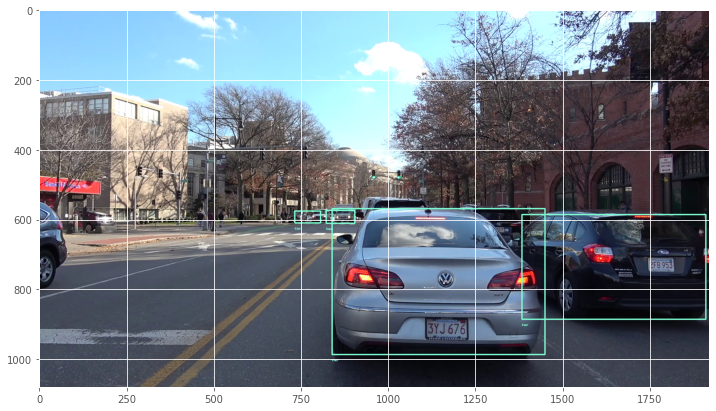

In [ ]:
# Load a sample image.
image = Image.open('sample.png')
image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)

with tf.Session(graph=detection_graph) as sess:                
    # Actual detection.
    (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: image_np})


    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)

    confidence_cutoff = 0.7
    # Filter boxes with a confidence score less than `confidence_cutoff`
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = image.size
    box_coords = to_image_coords(boxes, height, width)
 

    # Each class with be represented by a differently colored box
    draw_boxes(image, box_coords, classes)

    plt.figure(figsize=(12, 8))
    plt.imshow(image) 

## Timing Detection

The model zoo comes with a variety of models, each its benefits and costs. Below you'll time some of these models. The general tradeoff being sacrificing model accuracy for seconds per frame (SPF).

## Detection on a Video

Finally run your pipeline on [this short video](sample.mp4).

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:

from kora.drive import upload_public
url = upload_public('sample.mp4')
# then display it
from IPython.display import HTML
HTML(f"""<video src={url} width=500 controls/>""")

### Exercise 5 - Object Detection on a Video

Run an object detection pipeline on the above clip.

In [ ]:
clip = VideoFileClip('sample.mp4')

In [ ]:
# TODO: Complete this function.
# The input is an NumPy array.
# The output should also be a NumPy array.
def pipeline(img):
    draw_img = Image.fromarray(img)
    boxes, scores, classes = sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: np.expand_dims(img, 0)})
    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)
    
    confidence_cutoff = 0.7
    # Filter boxes with a confidence score less than `confidence_cutoff`
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)
    
    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = draw_img.size
    box_coords = to_image_coords(boxes, height, width)
    
    # Each class with be represented by a differently colored box
    draw_boxes(draw_img, box_coords, classes)
    return np.array(draw_img)

In [ ]:
with tf.Session(graph=detection_graph) as sess:
    image_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = sess.graph.get_tensor_by_name('detection_scores:0')
    detection_classes = sess.graph.get_tensor_by_name('detection_classes:0')
    
    new_clip = clip.fl_image(pipeline)
    
    # write to file
    new_clip.write_videofile('result.mp4')

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4



100%|██████████| 600/600 [04:09<00:00,  2.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



In [ ]:
url = upload_public('result.mp4')
# then display it
HTML(f"""<video src={url} width=500 controls/>""")

## Further Exploration

Some ideas to take things further:

* Finetune the model on a new dataset more relevant to autonomous vehicles. Instead of loading the frozen inference graph you'll load the checkpoint.
* Optimize the model and get the FPS as low as possible.
* Build your own detector. There are several base model pretrained on ImageNet you can choose from. [Keras](https://keras.io/applications/) is probably the quickest way to get setup in this regard.
